<a href="https://colab.research.google.com/github/Said20038/DeepLearning/blob/main/TP%20Classification%20Multiclass%20RGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Installation de la bibliothèque Kaggle pour télécharger la base de données
!pip install kaggle

# Importation des bibliothèques nécessaires
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab import files

print("Bibliothèques importées.")

# --- Configuration de l'API Kaggle ---
# Créez un dossier .kaggle et copiez-y votre fichier kaggle.json
# Ce fichier contient vos identifiants API Kaggle.
# Vous pouvez le télécharger depuis votre compte Kaggle > Settings > API > Create New Token
print("\n---")
print("Veuillez maintenant importer votre fichier 'kaggle.json'...")
if os.path.exists('kaggle.json'):
    os.remove('kaggle.json')

uploaded = files.upload()

if 'kaggle.json' in uploaded:
    print("'kaggle.json' importé avec succès !")
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
else:
    print("Erreur : Le fichier 'kaggle.json' n'a pas été importé.")

Bibliothèques importées.

---
Veuillez maintenant importer votre fichier 'kaggle.json'...


Saving kaggle.json to kaggle.json
'kaggle.json' importé avec succès !


In [2]:
# Téléchargement de la base de données AMHCD depuis Kaggle
# Lien de la base de données : https://www.kaggle.com/datasets/benaddym/amazigh-handwritten-character-database-amhcd
!kaggle datasets download -d benaddym/amazigh-handwritten-character-database-amhcd --unzip

print("\nBase de données AMHCD téléchargée et décompressée.")

Dataset URL: https://www.kaggle.com/datasets/benaddym/amazigh-handwritten-character-database-amhcd
License(s): other
 91% 62.0M/67.9M [00:00<00:00, 104MB/s]
100% 67.9M/67.9M [00:00<00:00, 97.8MB/s]

Base de données AMHCD téléchargée et décompressée.


In [3]:
# Cell 1 - Setup and Imports
!pip install psutil -q
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import psutil
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report

# Function to print memory usage
def print_memory_usage():
    process = psutil.Process(os.getpid())
    mem = process.memory_info().rss / 1024 ** 2  # Memory in MB
    print(f"Current memory usage: {mem:.2f} MB")

print("Setup complete. Initial memory usage:")
print_memory_usage()

Setup complete. Initial memory usage:
Current memory usage: 774.03 MB


In [4]:
# Cell 2 - Data Loading Function
def load_data(img_size=32):
    data = []
    labels = []

    # Define data path
    data_path = 'AMHCD_64/AMHCD_64/'
    print(f"Recherche des données dans le dossier : '{data_path}'")

    if not os.path.isdir(data_path):
        print(f"ERREUR : Le chemin de base '{data_path}' n'a pas été trouvé.")
        return None, None

    class_names = sorted(os.listdir(data_path))
    print(f"Trouvé {len(class_names)} dossiers de classe. Exemple : {class_names[:3]}")

    for label_index, class_name in enumerate(class_names):
        class_path = os.path.join(data_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            try:
                img_path = os.path.join(class_path, img_name)
                img = cv2.imread(img_path)
                if img is None:
                    print(f"Avertissement : Impossible de lire l'image {img_path}")
                    continue
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_resized = cv2.resize(img_gray, (img_size, img_size))
                data.append(img_resized)
                labels.append(label_index)
            except Exception as e:
                print(f"Erreur de traitement de l'image {img_path}: {e}")

    data = np.array(data, dtype="float32") / 255.0
    data = data.reshape((data.shape[0], img_size * img_size))
    labels = np.array(labels)
    print(f"Data shape after loading: {data.shape}, Memory usage after loading:")
    print_memory_usage()
    return data, labels

# Load data
print("Chargement des données...")
X, y = load_data()

if X is not None and y is not None and len(X) > 0:
    print(f"\nChargement des données réussi ! {len(X)} images chargées.")
else:
    print("\nLe chargement des données a échoué. Veuillez vérifier les messages d'erreur ci-dessus.")

Chargement des données...
Recherche des données dans le dossier : 'AMHCD_64/AMHCD_64/'
Trouvé 33 dossiers de classe. Exemple : ['ya', 'yab', 'yach']
Data shape after loading: (25740, 1024), Memory usage after loading:
Current memory usage: 905.08 MB

Chargement des données réussi ! 25740 images chargées.


Labels one-hot encoded. Shape: (25740, 33), Memory usage:
Current memory usage: 905.08 MB
Data augmented. New X shape: (51480, 1024), Memory usage:
Current memory usage: 1288.41 MB
Data standardized. Train Mean: -0.0002, Train Std: 1.0000, Memory usage:
Current memory usage: 1390.05 MB

Forme des données d'entraînement (X_train): (41184, 1024)
Forme des labels d'entraînement (y_train): (41184, 33)
Forme des données de test (X_test): (10296, 1024)
Forme des labels de test (y_test): (10296, 33)
Nombre total de classes: 33, Memory usage:
Current memory usage: 1390.05 MB


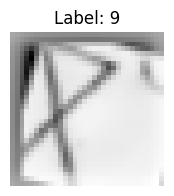

In [5]:
# Cell 3 - Data Preprocessing and Splitting (Corrigée)
if X is not None and y is not None and len(X) > 0:
    # One-Hot Encoding
    lb = LabelBinarizer()
    y_onehot = lb.fit_transform(y)
    print(f"Labels one-hot encoded. Shape: {y_onehot.shape}, Memory usage:")
    print_memory_usage()

    # Data augmentation
    def augment_image(img, target_size=(32, 32)):
        angle = np.random.uniform(-15, 15)
        M = cv2.getRotationMatrix2D((16, 16), angle, 1)
        img = cv2.warpAffine(img.reshape(32, 32), M, target_size)
        tx, ty = np.random.uniform(-3, 3, 2)
        M = np.float32([[1, 0, tx], [0, 1, ty]])
        img = cv2.warpAffine(img, M, target_size)
        return img.reshape(-1)

    X_augmented = np.array([augment_image(img) for img in X])
    y_augmented = np.tile(y_onehot, (len(X_augmented) // len(X), 1))
    X = np.vstack((X, X_augmented))
    y_onehot = np.vstack((y_onehot, y_augmented))
    print(f"Data augmented. New X shape: {X.shape}, Memory usage:")
    print_memory_usage()

    # Split data first
    X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, stratify=y_onehot)

    # Standardisation basée uniquement sur X_train
    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train_std[X_train_std == 0] = 1e-10  # Éviter la division par zéro
    X_train = (X_train - X_train_mean) / X_train_std
    X_test = (X_test - X_train_mean) / X_train_std  # Appliquer la même transformation au test set
    print(f"Data standardized. Train Mean: {np.mean(X_train):.4f}, Train Std: {np.std(X_train):.4f}, Memory usage:")
    print_memory_usage()

    print(f"\nForme des données d'entraînement (X_train): {X_train.shape}")
    print(f"Forme des labels d'entraînement (y_train): {y_train.shape}")
    print(f"Forme des données de test (X_test): {X_test.shape}")
    print(f"Forme des labels de test (y_test): {y_test.shape}")
    print(f"Nombre total de classes: {len(lb.classes_)}, Memory usage:")
    print_memory_usage()

    # Visualize an example
    plt.figure(figsize=(2, 2))
    plt.imshow(X_train[0].reshape(32, 32), cmap='gray')
    plt.title(f"Label: {np.argmax(y_train[0])}")
    plt.axis('off')
    plt.show()
else:
    print("\nAucune donnée à traiter après le chargement.")

In [6]:
# Cell 4 - Neural Network Definition
# Activation functions
def relu(x):
    """ReLU activation: max(0, x)"""
    return np.maximum(0, x)

def relu_derivative(x):
    """Derivative of ReLU: 1 if x > 0, else 0"""
    return np.where(x > 0, 1, 0)

def softmax(x):
    """Softmax activation: exp(x) / sum(exp(x))"""
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Avoid overflow
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

# Neural Network Class
class MultiClassNeuralNetwork:
    def __init__(self, layer_sizes, learning_rate=0.01, l2_lambda=0.001):
        self.layer_sizes = layer_sizes
        self.learning_rate = learning_rate
        self.l2_lambda = l2_lambda
        self.weights = [np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * 0.01 for i in range(len(layer_sizes) - 1)]
        self.biases = [np.zeros((1, layer_sizes[i + 1])) for i in range(len(layer_sizes) - 1)]
        self.m_w = [np.zeros_like(w) for w in self.weights]  # Momentum for Adam
        self.v_w = [np.zeros_like(w) for w in self.weights]  # RMSProp for Adam
        self.t = 0  # Iteration counter for Adam
        print(f"Network initialized with layers {layer_sizes}, Memory usage:")
        print_memory_usage()

    def forward(self, X):
        self.activations = [X]
        self.z_values = []
        for i in range(len(self.weights) - 1):
            z = np.dot(self.activations[i], self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            self.activations.append(relu(z))
        z = np.dot(self.activations[-1], self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        self.activations.append(softmax(z))
        return self.activations[-1]

    def compute_loss(self, y_true, y_pred):
        """Categorical Cross-Entropy with L2 regularization"""
        y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
        cross_entropy_loss = -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
        l2_loss = sum(np.sum(w ** 2) for w in self.weights) * self.l2_lambda / y_true.shape[0]
        return cross_entropy_loss + l2_loss

    def compute_accuracy(self, y_true, y_pred):
        return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

    def backward(self, X, y, outputs):
        m = X.shape[0]
        self.d_weights = [np.zeros_like(w) for w in self.weights]
        self.d_biases = [np.zeros_like(b) for b in self.biases]
        dZ = outputs - y
        self.d_weights[-1] = (self.activations[-2].T @ dZ) / m + (self.l2_lambda / m) * self.weights[-1]
        self.d_biases[-1] = np.sum(dZ, axis=0, keepdims=True) / m
        for i in range(len(self.weights) - 2, -1, -1):
            dZ = (dZ @ self.weights[i + 1].T) * relu_derivative(self.z_values[i])
            self.d_weights[i] = (self.activations[i].T @ dZ) / m + (self.l2_lambda / m) * self.weights[i]
            self.d_biases[i] = np.sum(dZ, axis=0, keepdims=True) / m

    def update_with_adam(self):
        self.t += 1
        beta1, beta2, epsilon = 0.9, 0.999, 1e-8
        self.m_w = [beta1 * m + (1 - beta1) * dw for m, dw in zip(self.m_w, self.d_weights)]
        self.v_w = [beta2 * v + (1 - beta2) * dw**2 for v, dw in zip(self.v_w, self.d_weights)]
        m_w_hat = [m / (1 - beta1**self.t) for m in self.m_w]
        v_w_hat = [v / (1 - beta2**self.t) for v in self.v_w]
        self.weights = [w - self.learning_rate * m / (np.sqrt(v) + epsilon) for w, m, v in zip(self.weights, m_w_hat, v_w_hat)]
        self.biases = [b - self.learning_rate * db / (np.sqrt(np.sum(db**2) / db.size + epsilon)) for b, db in zip(self.biases, self.d_biases)]

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
        for epoch in range(epochs):
            indices = np.random.permutation(X_train.shape[0])
            X_shuffled, y_shuffled = X_train[indices], y_train[indices]
            epoch_loss = 0
            for i in range(0, X_train.shape[0], batch_size):
                X_batch = X_shuffled[i:i + batch_size]
                y_batch = y_shuffled[i:i + batch_size]
                outputs = self.forward(X_batch)
                epoch_loss += self.compute_loss(y_batch, outputs)
                self.backward(X_batch, y_batch, outputs)
                self.update_with_adam()
            train_loss = epoch_loss / (X_train.shape[0] // batch_size)
            train_pred = self.forward(X_train)
            train_accuracy = self.compute_accuracy(y_train, train_pred)
            val_pred = self.forward(X_val)
            val_loss = self.compute_loss(y_val, val_pred)
            val_accuracy = self.compute_accuracy(y_val, val_pred)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_accuracy)
            val_accuracies.append(val_accuracy)
            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                      f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        print(f"Training complete. Final memory usage:")
        print_memory_usage()
        return train_losses, val_losses, train_accuracies, val_accuracies

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

print("Neural Network definition complete. Memory usage:")
print_memory_usage()

Neural Network definition complete. Memory usage:
Current memory usage: 1390.73 MB


In [ ]:
# Cell 5 - K-Fold Cross-Validation and Final Training
if X is not None and y is not None and len(X) > 0:
    # K-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_accuracies = []
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
        X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
        y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]
        nn = MultiClassNeuralNetwork(layer_sizes=[1024, 128, 64, len(lb.classes_)], learning_rate=0.01, l2_lambda=0.001)
        train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold, epochs=100, batch_size=32)
        val_pred = nn.predict(X_val_fold)
        fold_accuracy = np.mean(val_pred == np.argmax(y_val_fold, axis=1))
        fold_accuracies.append(fold_accuracy)
        print(f"Fold {fold + 1} Accuracy: {fold_accuracy:.4f}")

    print(f"Mean CV Accuracy: {np.mean(fold_accuracies):.4f} (±{np.std(fold_accuracies):.4f})")

    # Final training and evaluation
    nn = MultiClassNeuralNetwork(layer_sizes=[1024, 64, 32, len(lb.classes_)], learning_rate=0.01, l2_lambda=0.001)
    train_losses, val_losses, train_accuracies, val_accuracies = nn.train(X_train, y_train, X_test, y_test, epochs=100, batch_size=32)

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Final evaluation
    y_pred = nn.predict(X_test)
    print("\nClassification Report (Test set):")
    print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=[str(i) for i in range(len(lb.classes_))]))

    # Confusion Matrix
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(lb.classes_)), yticklabels=range(len(lb.classes_)))
    plt.title('Confusion Matrix (Test set)')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
else:
    print("\nAucune donnée à traiter après le chargement.")

Network initialized with layers [1024, 128, 64, 33], Memory usage:
Current memory usage: 1519.32 MB
Epoch 0, Train Loss: 2.2486, Val Loss: 1.9813, Train Acc: 0.4840, Val Acc: 0.4896
Epoch 10, Train Loss: 2.7258, Val Loss: 2.0071, Train Acc: 0.5066, Val Acc: 0.5003
Epoch 20, Train Loss: 2.6550, Val Loss: 1.8963, Train Acc: 0.5218, Val Acc: 0.5156
Epoch 30, Train Loss: 2.7027, Val Loss: 2.0667, Train Acc: 0.4791, Val Acc: 0.4661
Epoch 40, Train Loss: 2.5395, Val Loss: 1.9816, Train Acc: 0.5056, Val Acc: 0.4929
Epoch 50, Train Loss: 2.1675, Val Loss: 1.6156, Train Acc: 0.6262, Val Acc: 0.6045
Epoch 60, Train Loss: 1.8880, Val Loss: 1.4627, Train Acc: 0.6409, Val Acc: 0.6121
Epoch 70, Train Loss: 1.7201, Val Loss: 1.3466, Train Acc: 0.6932, Val Acc: 0.6657
Epoch 80, Train Loss: 1.5842, Val Loss: 1.1510, Train Acc: 0.7717, Val Acc: 0.7364
Epoch 90, Train Loss: 1.4955, Val Loss: 1.1987, Train Acc: 0.7739, Val Acc: 0.7402
Training complete. Final memory usage:
Current memory usage: 1750.12 MB